# SAR Image Colorization


## Import Libraries


In [1]:
import numpy as np
import pystac_client
from tqdm import tqdm
import tensorflow as tf
import planetary_computer
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Huber
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from Utilities.utils import get_data, build_and_split_images, process_and_save_images, postprocess_image

## Retrieving Data


In [2]:
X_dim, Y_dim = 256, 256

In [3]:
# catalog = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace,
# )

In [4]:
# bbox_of_interest = [20, 15, 135, 70]
# time_of_interest = "2023-12-27/2023-12-31"
# items = get_data(catalog, bbox_of_interest, time_of_interest)
# print(f"Found {len(items)} items")

In [5]:
# data = []
# for i in range(0, len(items), 200):
#     data.append(build_and_split_images(items[i:i+200]))

## Saving & Loading the Data


To save time and computational resources, we will load the data from the file


In [6]:
# processed_data = []
# for i in range(len(data)):
#     processed_data.append(process_and_save_images(data[i],i))

# lab_images = np.concatenate(processed_data, axis=0)
# lab_images = lab_images.astype(np.float32)
# np.save('lab_images.npy', lab_images)

In [7]:
lab_images = np.load('Data/lab_images.npy')
lab_images.shape

(1159, 256, 256, 3)

## Splitting the LAB images into L and AB channels


In [8]:
X = lab_images[:, :, :, 0].reshape(-1, X_dim, Y_dim, 1) / 100

Y = lab_images[:, :, :, 1:] / 128

## Splitting the Data into Train Test Split


In [9]:
np.random.seed(69)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y)

## Building the Neural Network


In [10]:
early_stopping = EarlyStopping(
    patience=5,
    min_delta=1e-4
)

In [11]:

tf.keras.backend.clear_session()
tf.random.set_seed(69)
tf.keras.backend.clear_session()
model = models.Sequential()

model.add(layers.Input(shape=(X_dim, X_dim, 1,)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Batch Normalization after Conv
model.add(layers.Conv2D(64, (3, 3), activation='relu',
          padding='same', strides=2))  # Downsample by 2
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu',
          padding='same', strides=2))  # Downsample by 2
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu',
          padding='same', strides=2))  # Downsample by 2
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())

# Deeper convolution layers
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(layers.Dense())
model.add(layers.BatchNormalization())

# Upsampling starts here
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Upsample by 2x
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Upsample by 2x
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Final upsampling to match input size
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Output layer: 2 channels for 'a' and 'b'
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(layers.Dense(2))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0002),
              loss=Huber(), metrics=['accuracy'])

# Model summary
model.summary()

2024-10-01 12:47:29,541 - WARNING - From c:\Users\hychh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 128, 64)   │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64, 64, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32, 32, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │       295,04

 Total params: 3,986,216 (15.21 MB)

 Trainable params: 3,982,440 (15.19 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Fitting Data on the Neural Network


In [12]:
# model.fit(XTrain, YTrain, epochs=20, batch_size=10,callbacks=[early_stopping])

## Saving the Model


In [13]:
# model.compile(optimizer=RMSprop(learning_rate=0.0002), loss=Huber(reduction='sum_over_batch_size'), metrics=['accuracy'])
# model.save('my_model.h5')

## Loading the Model


In [14]:
# Load the model without compiling
loaded_model = tf.keras.models.load_model('Model/my_model.h5', compile=False)

# Recompile the model with valid loss and reduction
loaded_model.compile(optimizer='RMSprop',
                     loss=Huber(reduction='sum_over_batch_size'),
                     metrics=['accuracy'])

## Evaluating the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-10-01 12:47:36,851 - INFO - Postprocessing image with shape (1, 1, 256, 256) and (1, 2, 256, 256)
2024-10-01 12:47:36,875 - INFO - Resized ab channels to shape (1, 2, 256, 256)
2024-10-01 12:47:36,882 - INFO - Concatenated L and ab channels to shape (1, 3, 256, 256)
2024-10-01 12:47:36,932 - INFO - Converted LAB image to RGB with shape (1, 3, 256, 256)
2024-10-01 12:47:36,946 - INFO - Resized image to original shape (256, 256)
2024-10-01 12:47:36,951 - INFO - Image postprocessed and converted to RGB with shape (256, 256, 3)


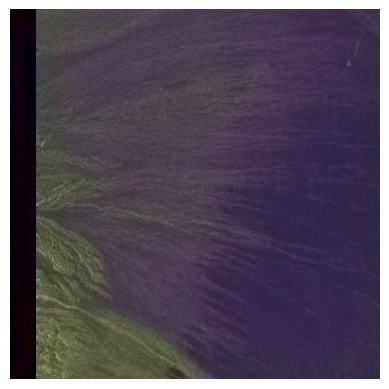

RGB Min: 0.0, RGB Max: 0.6893061995506287
Mean Squared Error (MSE) for image 69: 0.0094


In [15]:
image_no = 69

predicted_ab = loaded_model.predict(
    XTest[image_no].reshape(-1, X_dim, Y_dim, 1))

# Preprocessing step (assuming L channel is in the range [0, 1])
tens_orig_l = tf.convert_to_tensor(XTest[image_no].reshape(
    # L channel scaled to [0, 100]
    1, 1, X_dim, Y_dim) * 100, dtype=tf.float32)

# Convert predicted_ab to TensorFlow Tensor and scale it back to [-128, 128]
out_ab = tf.convert_to_tensor(predicted_ab, dtype=tf.float32)
out_ab = tf.transpose(out_ab, perm=[0, 3, 1, 2])  # Reshape from NHWC to NCHW
out_ab = out_ab * 128  # Scale the predicted ab channels

# Assuming postprocess_tens is a function that converts L and ab channels to RGB
predicted_rgb = postprocess_image(tens_orig_l, out_ab, (256,256))

# Visualize the image
plt.imshow(predicted_rgb)
plt.axis('off')
plt.show()

# Check the range of the predicted RGB image
print(f"RGB Min: {tf.reduce_min(predicted_rgb).numpy()}, RGB Max: {
      tf.reduce_max(predicted_rgb).numpy()}")
mse = np.mean((YTest[image_no] - predicted_ab) ** 2)
print(f"Mean Squared Error (MSE) for image {image_no}: {mse:.4f}")

In [16]:
loaded_model.evaluate(XTest, YTest)

10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.7963 - loss: 0.0049


[0.004990137182176113, 0.8021747469902039]